In [1]:
import os
import sys
import numpy as np
import IPython
from IPython.display import Audio
import importlib
import matplotlib.pyplot as plt

import torch

sys.path.append("..")
import wavernn.preprocess
import wavernn.train
import wavernn.dataset
import wavernn.model
from wavernn.hyperparams import hyperparams


../wavernn/train.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/markus/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/markus/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/markus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/markus/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/markus/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/markus/anacond

In [2]:
experiment_dir = "/mnt/voices/markus_home2/tacorn-experiment-james_new/"
gta_map_file = os.path.join(experiment_dir, "features/acoustic2wavegen/training/map.txt")
train_feats_dir = os.path.join(experiment_dir, "features/wavegen/")

In [3]:
def load_gta_map(path):
    return np.genfromtxt(path, delimiter='|', dtype=None)

In [4]:
gta_map = load_gta_map(gta_map_file)

In [5]:
# load data from some element of GTA map
(audio_file, mel_orig_file, mel_gta_file, _, text) = gta_map[4]
audio_file

b'/mnt/voices/markus_home2/tacorn-experiment-james_new/features/acoustic/audio/audio-4.npy'

# Load audio (numpy)

In [6]:
audio = np.load(audio_file.decode("utf-8"))
len(audio)

73975

Text(0.5,1,'Original audio')

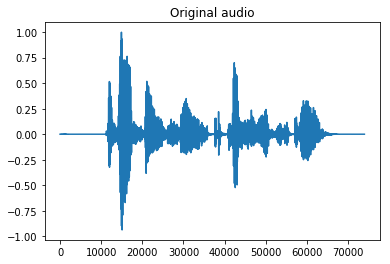

In [7]:
IPython.display.display(Audio(data=audio, rate=hyperparams.sample_rate))
plt.plot(audio)
plt.title("Original audio")

Text(0.5,1,'Quantized original audio')

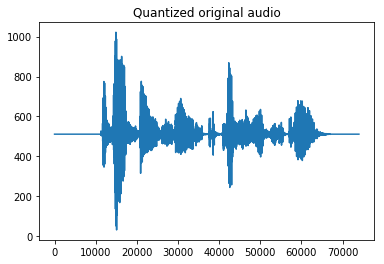

In [8]:
plt.plot(wavernn.audio.quantize(audio).astype(np.int))
plt.title("Quantized original audio")

# Load audio (librosa)

In [9]:
# e.g. 10 bit quantization
print(wavernn.hyperparams.hyperparams.input_type)
print(wavernn.hyperparams.hyperparams.bits)
audio_librosa = wavernn.preprocess.get_wav(audio_file.decode("utf-8")) 

bits
10


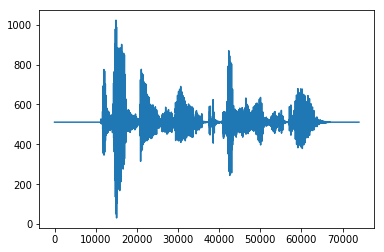

In [10]:
plt.plot(audio_librosa)

# Load dataset

In [11]:
importlib.reload(wavernn.dataset)
dataset = wavernn.dataset.AudiobookDataset(train_feats_dir)
if hyperparams.input_type == 'raw':                                                                                                                             
  collate_fn = wavernn.dataset.raw_collate                                                                                                                           
elif hyperparams.input_type == 'mixture':                                                                                                                       
  collate_fn = wavernn.dataset.raw_collate                                                                                                                           
elif hyperparams.input_type in ['bits', 'mulaw']:                                                                                                               
  collate_fn = wavernn.dataset.discrete_collate                                                                                                                      
else:                                                                                                                                                  
  raise ValueError("input_type:{} not supported".format(hyperparams.input_type))                                                                              
data_loader = wavernn.dataset.DataLoader(dataset, collate_fn=collate_fn, shuffle=False, num_workers=1, batch_size=hyperparams.batch_size)                                    

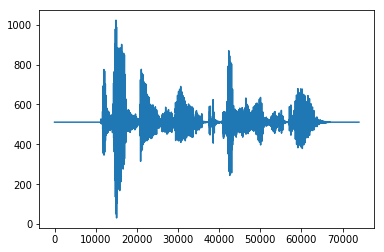

In [25]:
el = dataset[0]
plt.plot(el[1])

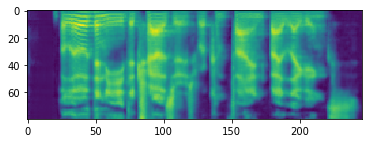

In [13]:
plt.imshow(el[0])

In [14]:
# first batch, containing audio, mel spec, audio
batch0 = next(iter(data_loader))
x, m, y = batch0

In [15]:
print(x.shape, m.shape, y.shape, hyperparams.seq_len)

torch.Size([32, 1375]) torch.Size([32, 80, 9]) torch.Size([32, 1375]) 1375


In [16]:
# first element of batch
x, m, y = x[0].numpy(), m[0].numpy(), y[0].numpy()

In [17]:
# y shifted to the right, 
# changed this: also x is in float range [-1.0, 1.0] while y is quantized
# now both are quantized
x.shape, m.shape, y.shape

((1375,), (80, 9), (1375,))

[469 517 539 490 461 517 525 483 496 514]


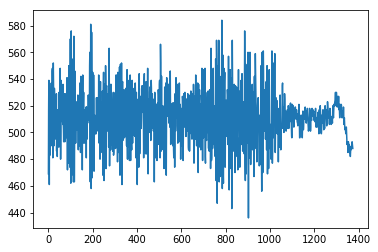

In [18]:
plt.plot(x)
#print(wavernn.audio.quantize(x[:10]))
print(x[:10])

[517 539 490 461 517 525 483 496 514 499]


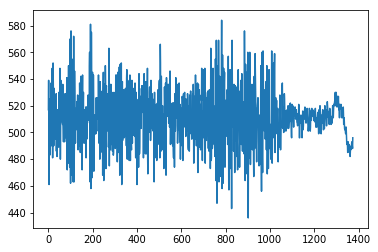

In [19]:
plt.plot(y)
print(y[:10])

# forward pass

In [20]:
n_classes = 2**hyperparams.bits
batch_size = hyperparams.batch_size
x, m, y = batch0
batch_len = x.shape[1]
x.shape

torch.Size([32, 1375])

In [21]:
# one hot encode x
netinput = torch.LongTensor(batch_size, batch_len, n_classes)
for b in range(batch_size):
    for l in range(batch_len):
        netinput[b, l, x[b, l]] = 1

In [22]:
torch.cat([netinput, netinput], dim=2).shape

torch.Size([32, 1375, 2048])

In [43]:
# encode using model function
importlib.reload(wavernn.model)
netinput = wavernn.model.encode_one_hot(x, n_classes)
torch.cat([netinput, netinput], dim=2).shape

torch.Size([32, 1375, 2048])

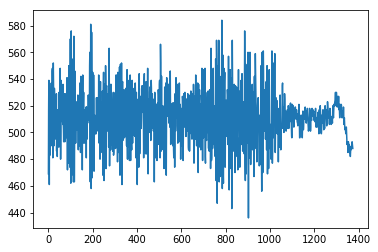

In [44]:
plt.plot(x[0].numpy())

In [45]:
print(torch.argmax(netinput[0][1]))
print(torch.argmax(netinput[0], dim=1))

tensor(517)
tensor([469, 517, 539,  ..., 491, 489, 488])


In [46]:
x_encdec = wavernn.model.decode_one_hot(netinput)
plt.plot(x_encdec[0].numpy())

torch.Size([32, 1375])